In [ ]:
%%capture

!pip install datasets unidecode

## Finetune - French

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset

from unidecode import unidecode
import os


model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def prepare_dataset(examples):
    texts = examples['text']
    new_texts = []
    for text in texts:
        text = unidecode(text)
        new_texts.append(text)
    return {'text': new_texts}


dataset = load_dataset('Sabrina1763/wikipedia_french', split='train[0:20000]')
dataset = dataset.map(prepare_dataset, batched=True)

def tokenize_function(examples):
    result = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    result['labels'] = result['input_ids'].clone()

    return result

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_dataset.set_format('torch')

# Prepare the Trainer
training_args = TrainingArguments(
    output_dir='./gpt2-french',
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    save_steps=5000,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=500,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./gpt2-french')
tokenizer.save_pretrained('./gpt2-french')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Step,Training Loss
500,3.438000
1000,2.978700


('./gpt2-french/tokenizer_config.json',
 './gpt2-french/special_tokens_map.json',
 './gpt2-french/vocab.json',
 './gpt2-french/merges.txt',
 './gpt2-french/added_tokens.json')

# load datasets

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline

base_model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load datasets
ds1 = load_dataset('wujohns/gpt2-base-learn', split="train[0:6000]")
ds2 = load_dataset('Sabrina1763/wikipedia_french', split='train[0:12000]')

# Create combined dataset with labels
combined_texts = []
combined_labels = []
for j in range(2):
    for i in ds1:
        combined_texts.append(i['text'])
        combined_labels.append(0)  # ds1 is better handled by base model
for i in ds2:
    combined_texts.append(i['text'])
    combined_labels.append(1)  # ds2 is better handled by fine-tuned model

print(f"Number of rows in combined_texts: {len(combined_texts)}")

dataset = Dataset.from_dict({"text": combined_texts, "label": combined_labels})

def tokenize_function(examples):
    outputs = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    return {'input_ids': outputs['input_ids'], 'attention_mask': outputs['attention_mask'], 'label': examples['label']}

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=[])
tokenized_datasets.set_format('torch')

sample_size = min(20000, len(tokenized_datasets))
train_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size))

val_size = int(0.1 * sample_size)
train_dataset = train_dataset.select(range(sample_size - val_size))
val_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size - val_size, sample_size))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

README.md:   0%|          | 0.00/424 [00:00<?, ?B/s]

(…)-00000-of-00001-6b54eae14da8a535.parquet:   0%|          | 0.00/4.51M [00:00<?, ?B/s]

Number of rows in combined_texts: 24000


Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

# Independent training

## Architecture

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
from torch.utils.data import DataLoader
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline

torch.manual_seed(123)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model_name, fine_tuned_model_name = 'gpt2', './gpt2-french'  # Replace with your fine-tuned model path
base_model = GPT2LMHeadModel.from_pretrained(base_model_name).to(device)
fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_name).to(device)

# Set requires_grad to False for base and fine-tuned models
for model in [base_model, fine_tuned_model]:
    for param in model.parameters():
        param.requires_grad = False

num_layers = len(base_model.transformer.h)
hidden_size = base_model.config.n_embd

# Updated BSplineAlpha class with quantized alpha values
class BSplineAlpha(nn.Module):
    def __init__(self, num_layers, hidden_size, num_control_points=16, degree=3):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_control_points = num_control_points
        self.degree = degree
        # Initialize control_points centered around 0 with small variance
        self.control_points = nn.Parameter(torch.randn(num_control_points, hidden_size, device=device) * 0.1)
        self.knot_vector = self._generate_knot_vector()
        self.register_buffer('basis_functions', self._compute_basis_functions())

        # Initialize layer-wise bias centered around zero
        self.layer_bias = nn.Parameter(torch.randn(num_layers, hidden_size, device=device))

    def _generate_knot_vector(self):
        num_knots = self.num_control_points + self.degree + 1
        knot_vector = np.linspace(0, 1, num_knots - 2 * self.degree)
        return np.concatenate((
            np.zeros(self.degree),
            knot_vector,
            np.ones(self.degree)
        ))

    def _compute_basis_functions(self):
        x = torch.linspace(0, 1, self.num_layers)
        basis_functions = np.zeros((self.num_layers, self.num_control_points))
        for i in range(self.num_control_points):
            coeffs = np.zeros(self.num_control_points)
            coeffs[i] = 1.0
            spline = BSpline(self.knot_vector, coeffs, self.degree)
            basis_functions[:, i] = spline(x.numpy())
        return torch.tensor(basis_functions, dtype=torch.float32, device=device)  # Shape: (num_layers, num_control_points)

    def forward(self):
        # Compute continuous alpha_values
        alpha_values = torch.einsum('ln,nh->lh', self.basis_functions, self.control_points) + self.layer_bias * 0.01
        alpha_values = torch.sigmoid(alpha_values)  # Values between 0 and 1

        # Scale alpha_values to be between 0.1 and 1.0
        alpha_values = alpha_values * 0.9 + 0.1

        # Quantize alpha_values to nearest 0.1
        quantized_alpha = torch.round(alpha_values, decimals=1)

        # Use STE for backpropagation
        quantized_alpha = quantized_alpha.detach() - alpha_values.detach() + alpha_values

        return quantized_alpha

    def compute_regularization_loss(self):
        # Regularization for control_points
        smoothness_loss = torch.mean((self.control_points[1:] - self.control_points[:-1]).pow(2))
        centrality_loss = torch.mean(self.control_points.pow(2))

        # Bias Regularization to encourage both negative and positive values
        mean_bias = torch.mean(self.layer_bias)
        mean_bias_loss = mean_bias.pow(2)  # Penalize if mean is not zero

        var_bias = torch.var(self.layer_bias)
        target_variance = 0.02  # Desired variance level
        variance_bias_loss = (var_bias - target_variance).pow(2)  # Penalize if variance deviates from target

        # Combine losses
        return smoothness_loss * 0.1 + centrality_loss * 0.1 + \
               (mean_bias_loss * 0.75 + variance_bias_loss * 0.25) * 0.05


bottleneck_size = int(hidden_size * 0.65)


class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class Conv1dWithPermute(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(Conv1dWithPermute, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        return x.contiguous()


class Autoencoder(nn.Module):
    def __init__(self, hidden_size, bottleneck_size):
        super().__init__()
        # Split bottleneck into main encoder and residual parts
        encoder_bottleneck_size = int(bottleneck_size * 0.8)
        residual_bottleneck_size = bottleneck_size - encoder_bottleneck_size

        # Low-rank bottleneck dimension, capped at 32
        rank = min(32, residual_bottleneck_size)

        # Low-rank adapter pathway for global features
        self.residual_adapter = nn.Sequential(
            nn.Linear(hidden_size, rank),         # Project down to low rank
            nn.ReLU(),
            nn.Linear(rank, residual_bottleneck_size)  # Project up to target size
        )

        # Main encoder pathway for local features
        self.encoder = nn.Sequential(
            Conv1dWithPermute(hidden_size, encoder_bottleneck_size, kernel_size=3, padding=1),  # Local feature extraction
            nn.GELU(),
            nn.LayerNorm(encoder_bottleneck_size),
        )

        # Decoder pathway to reconstruct input
        self.decoder = nn.Sequential(
            nn.Dropout(0.1),                     # Regularization
            Conv1dWithPermute(bottleneck_size, hidden_size, kernel_size=3, padding=1),  # Reconstruct original size
        )

    def forward(self, x):
        encoded = self.encoder(x)                # Get local features
        residual = self.residual_adapter(x)      # Get global features
        combined = torch.cat([encoded, residual], dim=-1)  # Combine both pathways
        decoded = self.decoder(combined)         # Reconstruct input
        return decoded


# MergedModel class
class MergedModel(nn.Module):
    def __init__(self, base_model, fine_tuned_model, alpha_module, autoencoders):
        super(MergedModel, self).__init__()
        self.base_model = base_model
        self.fine_tuned_model = fine_tuned_model
        self.alpha_module = alpha_module
        self.autoencoders = autoencoders

    def forward(self, input_ids, attention_mask=None, output_hidden_states=False, return_dict=False):
        alpha_values = self.alpha_module()  # Shape: (num_layers, hidden_size)

        # Get base model outputs
        base_outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        base_hidden_states = base_outputs.hidden_states

        # Get fine-tuned model outputs
        fine_tuned_outputs = self.fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        fine_tuned_hidden_states = fine_tuned_outputs.hidden_states

        # Embedding layer (Layer 0)
        base_h = base_hidden_states[0]  # Shape: (batch_size, seq_len, hidden_size)
        fine_tuned_h = fine_tuned_hidden_states[0]
        # Average the embeddings
        blended_h = (base_h + fine_tuned_h) / 2

        reconstructed_hidden_states = []
        reconstructed_hidden_states.append(blended_h)  # No autoencoder applied

        blended_hidden_states = []
        blended_hidden_states.append(blended_h)

        for idx in range(1, len(base_hidden_states)):

            autoencoder_idx = idx - 1

            base_h = base_hidden_states[idx]  # Shape: (batch_size, seq_len, hidden_size)
            fine_tuned_h = fine_tuned_hidden_states[idx]

            alpha = alpha_values[autoencoder_idx]  # Shape: (hidden_size,)

            # Reshape alpha to match hidden state dimensions
            alpha = alpha.view(1, 1, -1)  # Shape: (1, 1, hidden_size)
            blended_h = (1 - alpha) * base_h + alpha * fine_tuned_h

            # Pass blended hidden state through the corresponding autoencoder (layer 4 to layer 11)
            if autoencoder_idx >= 3 and autoencoder_idx <= 10:
                h_recon = self.autoencoders[autoencoder_idx](blended_h)
            else:
                h_recon = blended_h

            reconstructed_hidden_states.append(h_recon)
            blended_hidden_states.append(blended_h)

        # For the final output, compute the logits based on the last reconstructed hidden state
        last_hidden_state = reconstructed_hidden_states[-1]
        logits = self.base_model.lm_head(last_hidden_state)

        output = {'logits': logits}
        if output_hidden_states:
            output['hidden_states'] = reconstructed_hidden_states  # Return reconstructed hidden states
            output['blended_hidden_states'] = blended_hidden_states
        if return_dict:
            return output
        else:
            return logits

## Training loop

In [ ]:
# Training loop
criterion_mse = nn.MSELoss()
criterion_cosine = nn.CosineSimilarity(dim=-1)

torch.manual_seed(123)

alpha_module = BSplineAlpha(num_layers=num_layers, hidden_size=hidden_size).to(device)
autoencoders = nn.ModuleList([
    Autoencoder(hidden_size, bottleneck_size).to(device)
    for _ in range(num_layers)  # Including embeddings layer
])

merged_model = MergedModel(base_model, fine_tuned_model, alpha_module, autoencoders).to(device)

# Initialize optimizer
optimizer_params = [
    {'params': alpha_module.parameters(), 'lr': 3e-4},
    {'params': autoencoders.parameters(), 'lr': 1e-4}
]
optimizer = torch.optim.AdamW(optimizer_params, weight_decay=1e-2)

In [ ]:
num_epochs = 8
clip_value = 1.0

# Initialize lists to store losses
epoch_losses = []
epoch_lm_losses = []
epoch_recon_losses = []

for epoch in range(num_epochs):
    total_loss, total_lm_loss, total_recon_loss = 0, 0, 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = merged_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        logits = outputs['logits']
        reconstructed_hidden_states = outputs['hidden_states']
        alpha_values = merged_model.alpha_module()

        # Language modeling loss computed with logits from reconstructed hidden states
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()
        lm_loss = nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Compute reconstruction loss with contrastive approach and include MSE and L2 losses
        recon_loss = 0

        with torch.no_grad():
            base_outputs = base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            base_hidden_states = base_outputs.hidden_states

            fine_tuned_outputs = fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            fine_tuned_hidden_states = fine_tuned_outputs.hidden_states

        for idx in range(1, len(base_hidden_states)):
            h_recon = reconstructed_hidden_states[idx]

            # Get the target and non-target hidden states
            h_base = base_hidden_states[idx].detach()
            h_finetuned = fine_tuned_hidden_states[idx].detach()

            labels_expanded = labels.view(-1, 1, 1).float()
            target_hidden_state = h_base * (1 - labels_expanded) + h_finetuned * labels_expanded

            # Flatten the tensors
            h_recon_flat = h_recon.view(-1, hidden_size)
            target_flat = target_hidden_state.view(-1, hidden_size)

            # Compute MSE loss with target
            mse_loss_layer = criterion_mse(h_recon_flat, target_flat)

            # Compute L2 loss (Euclidean distance)
            l2_loss_layer = torch.norm(h_recon_flat - target_flat, p=2, dim=-1).mean()

            # Combine losses
            recon_loss_layer = mse_loss_layer * 0.9 + l2_loss_layer * 0.1

            recon_loss += recon_loss_layer

        alpha_reg_loss = alpha_module.compute_regularization_loss()

        # Adjusted loss scaling
        loss = recon_loss * 1.0 + lm_loss * 0.2 + alpha_reg_loss * 0.1  # Adjust weights as needed

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(autoencoders.parameters(), clip_value)
        torch.nn.utils.clip_grad_norm_(alpha_module.parameters(), clip_value)

        optimizer.step()

        total_loss += loss.item()
        total_lm_loss += lm_loss.item()
        total_recon_loss += recon_loss.item()

        progress_bar.set_postfix({
            'loss': f"{loss.item():.6f}",
            'lm_loss': f"{lm_loss.item():.6f}",
            'recon_loss': f"{recon_loss.item():.6f}",
            'alpha_reg_loss': f"{alpha_reg_loss.item():.6f}",
        })

    avg_loss = total_loss / len(train_loader)
    avg_lm_loss = total_lm_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.6f}, Avg LM Loss: {avg_lm_loss:.6f}, Avg Recon Loss: {avg_recon_loss:.6f}")

    print("\nCurrent alpha values:")
    alpha_values = merged_model.alpha_module().detach().cpu().numpy()
    print(alpha_values)

print("\nTraining completed")

Epoch 1/8: 100%|██████████| 563/563 [07:30<00:00,  1.25it/s, loss=116.939056, lm_loss=3.887434, recon_loss=116.159950, alpha_reg_loss=0.016140]


Epoch 1/8, Avg Loss: 520.728477, Avg LM Loss: 3.684952, Avg Recon Loss: 519.989983

Current alpha values:
[[0.6 0.6 0.5 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 ...
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.5 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.5 ... 0.6 0.6 0.6]]


Epoch 2/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=61.081169, lm_loss=3.845090, recon_loss=60.310452, alpha_reg_loss=0.017031]


Epoch 2/8, Avg Loss: 73.643974, Avg LM Loss: 3.679451, Avg Recon Loss: 72.906443

Current alpha values:
[[0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 ...
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]]


Epoch 3/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=53.444023, lm_loss=3.824079, recon_loss=52.677155, alpha_reg_loss=0.020505]


Epoch 3/8, Avg Loss: 55.781009, Avg LM Loss: 3.674637, Avg Recon Loss: 55.044226

Current alpha values:
[[0.7 0.7 0.6 ... 0.6 0.7 0.6]
 [0.6 0.7 0.6 ... 0.7 0.6 0.6]
 [0.6 0.6 0.6 ... 0.7 0.7 0.6]
 ...
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.6 0.6 0.6 ... 0.6 0.7 0.6]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]]


Epoch 4/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=49.820290, lm_loss=3.532265, recon_loss=49.111271, alpha_reg_loss=0.025686]


Epoch 4/8, Avg Loss: 51.463427, Avg LM Loss: 3.667506, Avg Recon Loss: 50.727626

Current alpha values:
[[0.7 0.7 0.6 ... 0.7 0.7 0.6]
 [0.7 0.7 0.6 ... 0.7 0.7 0.7]
 [0.6 0.7 0.6 ... 0.7 0.7 0.6]
 ...
 [0.7 0.6 0.6 ... 0.7 0.7 0.6]
 [0.6 0.6 0.7 ... 0.7 0.7 0.6]
 [0.7 0.6 0.6 ... 0.7 0.6 0.7]]


Epoch 5/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=47.129456, lm_loss=3.645002, recon_loss=46.397243, alpha_reg_loss=0.032118]


Epoch 5/8, Avg Loss: 49.339121, Avg LM Loss: 3.664984, Avg Recon Loss: 48.603226

Current alpha values:
[[0.7 0.7 0.7 ... 0.7 0.7 0.6]
 [0.7 0.7 0.6 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 ...
 [0.7 0.6 0.6 ... 0.7 0.7 0.6]
 [0.7 0.7 0.7 ... 0.7 0.7 0.6]
 [0.7 0.6 0.6 ... 0.7 0.7 0.7]]


Epoch 6/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=46.809628, lm_loss=3.754690, recon_loss=46.054726, alpha_reg_loss=0.039650]


Epoch 6/8, Avg Loss: 48.067602, Avg LM Loss: 3.665160, Avg Recon Loss: 47.330989

Current alpha values:
[[0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 ...
 [0.7 0.7 0.7 ... 0.7 0.7 0.6]
 [0.7 0.7 0.7 ... 0.7 0.7 0.6]
 [0.7 0.6 0.6 ... 0.7 0.7 0.7]]


Epoch 7/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=46.603310, lm_loss=3.688441, recon_loss=45.860802, alpha_reg_loss=0.048185]


Epoch 7/8, Avg Loss: 47.307015, Avg LM Loss: 3.662884, Avg Recon Loss: 46.570059

Current alpha values:
[[0.8 0.8 0.7 ... 0.7 0.8 0.7]
 [0.7 0.8 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 ...
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]]


Epoch 8/8: 100%|██████████| 563/563 [07:29<00:00,  1.25it/s, loss=49.403889, lm_loss=3.754118, recon_loss=48.647377, alpha_reg_loss=0.056875]

Epoch 8/8, Avg Loss: 46.752666, Avg LM Loss: 3.661031, Avg Recon Loss: 46.015222

Current alpha values:
[[0.8 0.8 0.7 ... 0.7 0.8 0.7]
 [0.7 0.8 0.7 ... 0.8 0.8 0.8]
 [0.7 0.8 0.7 ... 0.7 0.8 0.7]
 ...
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.8 0.7 0.7]]

Training completed


## Quick Visualizations

In [ ]:
# Define models to evaluate
# Build the merged model
merged_model.eval()  # Set to evaluation mode

alpha_module.eval()
autoencoders.eval()

models_to_evaluate = {
    'base': base_model,
    'fine_tuned': fine_tuned_model,
    'merged_with_autoencoders': merged_model,
}

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


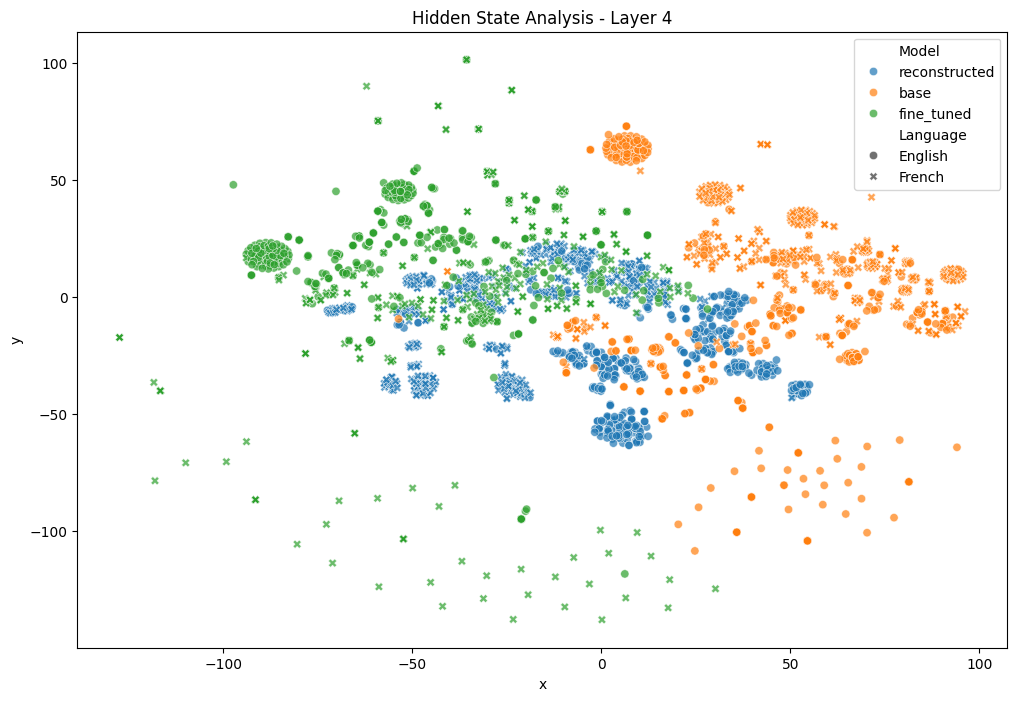


Reconstruction Similarities:
Reconstructed vs Base Model          0.9999
Reconstructed vs Fine-tuned Model    0.9999
dtype: float32


In [ ]:

# Visualization code remains the same
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def analyze_hidden_state_reconstruction(
    models: dict,
    eval_dataset,
    device: torch.device,
    num_samples: int = 1000,
    layer_idx: int = 4
) -> None:
    """Analyze reconstruction quality for inputs."""
    dataloader = torch.utils.data.DataLoader(
        eval_dataset.shuffle(seed=42).select(range(num_samples)),
        batch_size=32,
        shuffle=False
    )

    states = {model_type: [] for model_type in ['reconstructed', 'base', 'fine_tuned']}
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'output_hidden_states': True,
                'return_dict': True
            }

            # Collect hidden states from each model
            states['reconstructed'].append(
                models['merged_model'](**inputs)["hidden_states"][layer_idx][:, 0].cpu()
            )
            states['base'].append(
                models['base_model'](**inputs)["hidden_states"][layer_idx][:, 0].cpu()
            )
            states['fine_tuned'].append(
                models['fine_tuned_model'](**inputs)["hidden_states"][layer_idx][:, 0].cpu()
            )
            labels_list.append(batch['label'])

    # Concatenate and convert to numpy
    states = {k: torch.cat(v).numpy() for k, v in states.items()}
    labels_array = torch.cat(labels_list).numpy()

    # Visualize
    combined = np.vstack([states[k] for k in states])
    model_labels = sum([[k] * len(states[k]) for k in states], [])
    sample_labels = np.tile(labels_array, 3)  # Repeat labels for each model type

    # t-SNE with adjusted parameters
    embedded = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        init='pca',
        random_state=42
    ).fit_transform(combined)

    df = pd.DataFrame({
        'x': embedded[:, 0],
        'y': embedded[:, 1],
        'Model': model_labels,
        'Language': ['English' if l == 0 else 'French' for l in sample_labels]
    })

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='Model',
        style='Language',
        alpha=0.7
    )
    plt.title(f'Hidden State Analysis - Layer {layer_idx}')
    plt.show()

    # Compute similarities
    cos_sim = lambda a, b: np.mean([
        np.dot(a[i], b[i]) / (np.linalg.norm(a[i]) * np.linalg.norm(b[i]))
        for i in range(len(a))
    ])

    similarities = {
        'Reconstructed vs Base Model': cos_sim(states['reconstructed'], states['base']),
        'Reconstructed vs Fine-tuned Model': cos_sim(states['reconstructed'], states['fine_tuned'])
    }

    print("\nReconstruction Similarities:")
    print(pd.Series(similarities).round(4))

# Prepare models dictionary
models_to_evaluate = {
    'merged_model': merged_model.eval(),
    'base_model': base_model.eval(),
    'fine_tuned_model': fine_tuned_model.eval()
}

# Assuming you have a validation dataset `val_dataset`
analyze_hidden_state_reconstruction(
    models=models_to_evaluate,
    eval_dataset=val_dataset,
    device=device
)


## Export

In [ ]:
# Build the merged model
merged_model.eval()  # Set to evaluation mode

alpha_module.eval()
autoencoders.eval()

# Save the trained alpha_module and autoencoders
torch.save({
    'alpha_module_state_dict': alpha_module.state_dict(),
    'autoencoders_state_dict': autoencoders.state_dict(),
}, 'merged_model_params.pt')

print("Model parameters saved to merged_model_params.pt")

Model parameters saved to merged_model_params.pt


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params_alpha = count_parameters(alpha_module)
print(f"Number of alpha trainable parameters: {num_params_alpha}")

num_params_autoenc = count_parameters(autoencoders)
print(f"Number of autoencoders trainable parameters: {num_params_autoenc}")

Number of alpha trainable parameters: 21504
Number of autoencoders trainable parameters: 25186380


# Inference

## Inference architecture

In [ ]:
class MergedModel(nn.Module):
    def __init__(self, base_model, fine_tuned_model, alpha_module, autoencoders):
        super(MergedModel, self).__init__()
        self.base_model = base_model
        self.fine_tuned_model = fine_tuned_model
        self.alpha_module = alpha_module
        self.autoencoders = autoencoders

        # Assuming both models share the same configuration
        self.config = base_model.config

        # Extract transformer blocks from both models
        self.base_blocks = base_model.transformer.h
        self.fine_tuned_blocks = fine_tuned_model.transformer.h

        # Store both base and fine-tuned embeddings
        self.base_wte = base_model.transformer.wte  # Base token embeddings
        self.base_wpe = base_model.transformer.wpe  # Base position embeddings
        self.ft_wte = fine_tuned_model.transformer.wte  # Fine-tuned token embeddings
        self.ft_wpe = fine_tuned_model.transformer.wpe  # Fine-tuned position embeddings

        self.drop = base_model.transformer.drop  # Dropout layer
        self.ln_f = base_model.transformer.ln_f  # Final layer norm

        # Language modeling head
        self.lm_head = base_model.lm_head

    def forward(self, input_ids, attention_mask=None, output_hidden_states=False, return_dict=False):
        device = input_ids.device

        # Get alpha values and compute mean along dim=0 for embedding blending
        alpha_values = self.alpha_module()
        mean_alpha = torch.mean(alpha_values, dim=0)  # Average alpha across layers

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        # Prepare attention mask
        batch_size, seq_length = input_ids.size()
        causal_mask = torch.tril(torch.ones((seq_length, seq_length), device=device)).unsqueeze(0).unsqueeze(0)
        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask * causal_mask
        attention_mask = attention_mask.to(dtype=self.base_model.dtype)  # For fp16 compatibility
        attention_mask = (1.0 - attention_mask) * -10000.0  # Masked positions

        # Compute position ids
        position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # Blend embeddings using mean alpha
        base_embeddings = self.base_wte(input_ids) + self.base_wpe(position_ids)
        ft_embeddings = self.ft_wte(input_ids) + self.ft_wpe(position_ids)

        # Use mean_alpha for blending embeddings
        hidden_states = (1 - mean_alpha) * base_embeddings + mean_alpha * ft_embeddings
        hidden_states = self.drop(hidden_states)

        if output_hidden_states:
            all_hidden_states = [hidden_states]

        # Sequentially pass through transformer blocks and autoencoders
        num_layers = len(self.base_blocks)

        all_blended_hidden_states = []
        for idx in range(num_layers):
            base_block = self.base_blocks[idx]
            fine_tuned_block = self.fine_tuned_blocks[idx]

            # Base and fine-tuned outputs
            base_outputs = base_block(hidden_states, attention_mask=attention_mask)
            base_hidden_states = base_outputs[0]

            fine_tuned_outputs = fine_tuned_block(hidden_states, attention_mask=attention_mask)
            fine_tuned_hidden_states = fine_tuned_outputs[0]

            # Blend hidden states using layer-specific alpha
            alpha = alpha_values[idx]
            alpha = alpha.view(1, 1, -1)
            blended_hidden_state = (1 - alpha) * base_hidden_states + alpha * fine_tuned_hidden_states

            all_blended_hidden_states.append(blended_hidden_state)

            # Pass through autoencoder
            autoencoder_idx = idx  # Index matches the layer index

            if autoencoder_idx >= 3 and autoencoder_idx <= 10:
                reconstructed_hidden_state = self.autoencoders[autoencoder_idx](blended_hidden_state)
            else:
                reconstructed_hidden_state = blended_hidden_state

            # Input for the next layer
            hidden_states = reconstructed_hidden_state

            if output_hidden_states:
                all_hidden_states.append(hidden_states)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        if output_hidden_states:
            all_hidden_states.append(hidden_states)

        # Compute logits
        logits = self.lm_head(hidden_states)

        if not return_dict:
            return logits

        outputs = {'logits': logits}
        if output_hidden_states:
            outputs['hidden_states'] = all_hidden_states
            outputs['blended_hidden_states'] = all_blended_hidden_states
        return outputs

## Load checkpoints

In [ ]:
alpha_module = BSplineAlpha(num_layers=num_layers, hidden_size=hidden_size).to(device)
autoencoders = nn.ModuleList([
    Autoencoder(hidden_size, bottleneck_size).to(device)
    for _ in range(num_layers)
])

checkpoint = torch.load('merged_model_params.pt', map_location=device)
alpha_module.load_state_dict(checkpoint['alpha_module_state_dict'])
autoencoders.load_state_dict(checkpoint['autoencoders_state_dict'])

merged_model = MergedModel(base_model, fine_tuned_model, alpha_module, autoencoders).to(device)

merged_model.eval()
alpha_module.eval()
autoencoders.eval()

# Print current alpha values
print("\nCurrent alpha values:")
alpha_values = merged_model.alpha_module().detach().cpu().numpy()
print(alpha_values)


Current alpha values:
[[0.8 0.8 0.7 ... 0.7 0.8 0.7]
 [0.7 0.8 0.7 ... 0.8 0.8 0.8]
 [0.7 0.8 0.7 ... 0.7 0.8 0.7]
 ...
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]
 [0.7 0.7 0.7 ... 0.8 0.7 0.7]]


<ipython-input-10-b60ad5daed03>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('merged_model_params.pt', map_location=device)


# Evaluation

In [ ]:
%%capture

!pip install torchmetrics
!pip install umap-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import BSpline

import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics.text import BLEUScore
from torchmetrics.text.rouge import ROUGEScore

from collections import defaultdict
from typing import List, Dict

from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

import logging

import umap.umap_ as umap
UMAP_AVAILABLE = True

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Polysemantic Neurons Analysis
def compute_polysemantic_neurons(model, dataloader, layer_num):
    model.eval()
    activations = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Collecting Activations for Layer {layer_num}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label'].numpy()
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            hidden_states = outputs["hidden_states"][layer_num].mean(dim=1).cpu().numpy()
            activations.append(hidden_states)
            labels.extend(batch_labels)
    activations = np.concatenate(activations, axis=0)
    labels = np.array(labels)
    # Separate activations
    activations_eng = activations[labels == 0]
    activations_fr = activations[labels == 1]
    # Compute average activations
    avg_activation_eng = activations_eng.mean(axis=0)
    avg_activation_fr = activations_fr.mean(axis=0)
    # Compute normalized differences
    activation_diff = np.abs(avg_activation_eng - avg_activation_fr)
    max_activation = np.maximum(np.abs(avg_activation_eng), np.abs(avg_activation_fr))
    max_activation[max_activation == 0] = 1e-8
    normalized_diff = activation_diff / max_activation
    # Identify polysemantic neurons
    threshold = 0.05  # Adjust threshold as needed
    num_polysemantic_neurons = np.sum(normalized_diff < threshold)
    percentage_polysemantic = (num_polysemantic_neurons / len(normalized_diff)) * 100
    # Compute sparsity
    sparsity = np.mean(np.abs(activations) < 1e-4) * 100
    return sparsity, percentage_polysemantic


layer_num = 4

sparsity_base, percentage_polysemantic_base = compute_polysemantic_neurons(base_model, val_loader, layer_num)
sparsity_finetuned, percentage_polysemantic_finetuned = compute_polysemantic_neurons(fine_tuned_model, val_loader, layer_num)
sparsity_merged, percentage_polysemantic_merged = compute_polysemantic_neurons(merged_model, val_loader, layer_num)

print(f'Base Model - Sparsity: {sparsity_base:.6f}%, Polysemantic Neurons: {percentage_polysemantic_base:.6f}%')
print(f'Fine-Tuned Model - Sparsity: {sparsity_finetuned:.6f}%, Polysemantic Neurons: {percentage_polysemantic_finetuned:.6f}%')
print(f'Merged Model - Sparsity: {sparsity_merged:.6f}%, Polysemantic Neurons: {percentage_polysemantic_merged:.6f}%')


Base Model - Sparsity: 0.016602%, Polysemantic Neurons: 1.822917%
Fine-Tuned Model - Sparsity: 0.015495%, Polysemantic Neurons: 2.083333%
Merged Model - Sparsity: 0.017969%, Polysemantic Neurons: 3.385417%


## Additional Eval (PolySemantic)

In [ ]:
eval_dataset = tokenized_datasets.shuffle(seed=42).select(range(200))
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)


Analyzing Layer 3...
Analyzing Base Model...


Analyzing Layer 3: 100%|██████████| 768/768 [01:34<00:00,  8.08it/s]


Analyzing Fine-Tuned Model...


Analyzing Layer 3: 100%|██████████| 768/768 [01:33<00:00,  8.19it/s]


Analyzing Merged Model...


Analyzing Layer 3: 100%|██████████| 768/768 [01:36<00:00,  7.98it/s]



Analyzing Layer 4...
Analyzing Base Model...


Analyzing Layer 4: 100%|██████████| 768/768 [01:35<00:00,  8.08it/s]


Analyzing Fine-Tuned Model...


Analyzing Layer 4: 100%|██████████| 768/768 [01:36<00:00,  7.96it/s]


Analyzing Merged Model...


Analyzing Layer 4: 100%|██████████| 768/768 [01:34<00:00,  8.12it/s]



Analyzing Layer 5...
Analyzing Base Model...


Analyzing Layer 5: 100%|██████████| 768/768 [01:34<00:00,  8.13it/s]


Analyzing Fine-Tuned Model...


Analyzing Layer 5: 100%|██████████| 768/768 [01:36<00:00,  7.95it/s]


Analyzing Merged Model...


Analyzing Layer 5: 100%|██████████| 768/768 [01:34<00:00,  8.13it/s]



Analyzing Layer 6...
Analyzing Base Model...


Analyzing Layer 6: 100%|██████████| 768/768 [01:34<00:00,  8.13it/s]


Analyzing Fine-Tuned Model...


Analyzing Layer 6: 100%|██████████| 768/768 [01:36<00:00,  7.93it/s]


Analyzing Merged Model...


Analyzing Layer 6: 100%|██████████| 768/768 [01:34<00:00,  8.12it/s]


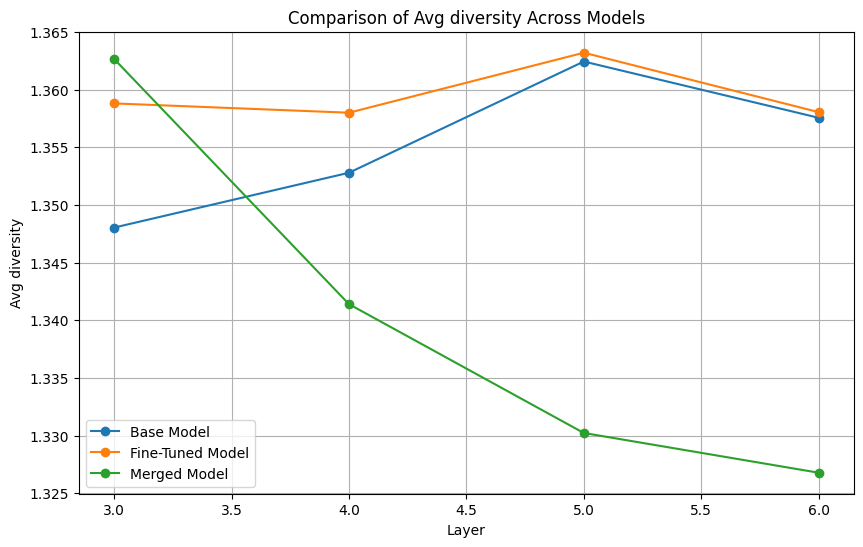

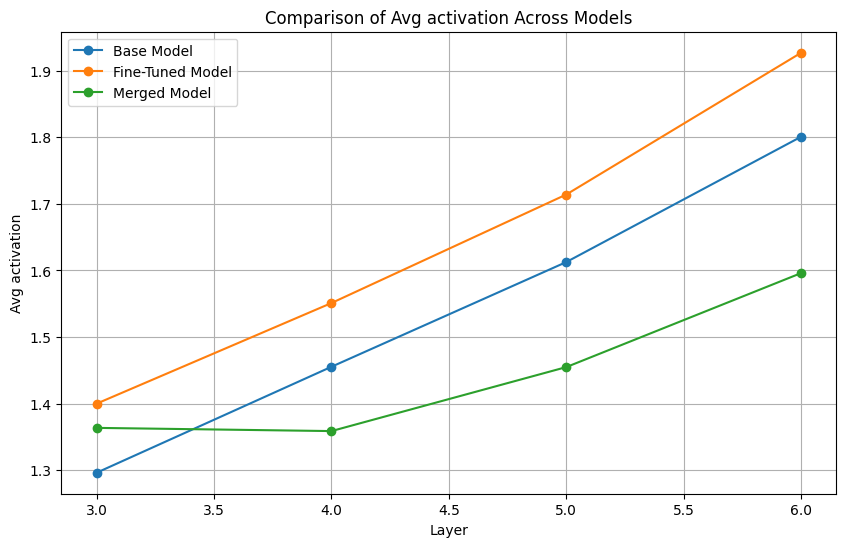

In [ ]:
import torch
import numpy as np
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from collections import defaultdict
from tqdm import tqdm


class ComparativePolysemanticAnalyzer:
    def __init__(self, num_clusters=5, activation_threshold=0.1, max_samples=100):
        self.num_clusters = num_clusters
        self.activation_threshold = activation_threshold
        self.max_samples = max_samples

    def collect_layer_activations(self, model, dataloader, layer_idx):
        model.eval()
        activations = []
        contexts = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(next(model.parameters()).device)
                attention_mask = batch['attention_mask'].to(next(model.parameters()).device)

                outputs = model(
                    input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )

                layer_activations = outputs['hidden_states'][layer_idx]
                activations.append(layer_activations.cpu().numpy())
                contexts.append(input_ids.cpu().numpy())

        activations = np.concatenate(activations, axis=0)
        contexts = np.concatenate(contexts, axis=0)

        return activations, contexts

    def compute_neuron_diversity(self, activations, contexts, neuron_idx):
        neuron_activations = activations[:, :, neuron_idx].reshape(-1)
        seq_length = activations.shape[1]

        expanded_contexts = np.repeat(contexts[:, np.newaxis, :], seq_length, axis=1)
        flattened_contexts = expanded_contexts.reshape(-1, expanded_contexts.shape[-1])

        top_k = min(self.max_samples, len(neuron_activations))
        top_indices = np.argsort(neuron_activations)[-top_k:]

        contexts_filtered = flattened_contexts[top_indices]

        vocab_size = 1000
        context_features = np.zeros((len(contexts_filtered), vocab_size))

        for i, context in enumerate(contexts_filtered):
            tokens, counts = np.unique(context[context < vocab_size], return_counts=True)
            context_features[i, tokens] = counts

        row_sums = context_features.sum(axis=1, keepdims=True)
        context_features = np.divide(context_features, row_sums, where=row_sums != 0)

        kmeans = MiniBatchKMeans(n_clusters=min(self.num_clusters, len(contexts_filtered)), random_state=42)
        clusters = kmeans.fit_predict(context_features)

        cluster_dist = np.bincount(clusters, minlength=self.num_clusters)
        cluster_dist = cluster_dist / cluster_dist.sum()

        return entropy(cluster_dist)

    def analyze_model_layer(self, model, dataloader, layer_idx):
        activations, contexts = self.collect_layer_activations(model, dataloader, layer_idx)
        hidden_size = activations.shape[-1]

        results = {}
        for neuron_idx in tqdm(range(hidden_size), desc=f"Analyzing Layer {layer_idx}"):
            if np.mean(np.abs(activations[:, :, neuron_idx])) < self.activation_threshold:
                continue  # Skip inactive neurons

            diversity = self.compute_neuron_diversity(activations, contexts, neuron_idx)
            mean_activation = np.mean(np.abs(activations[:, :, neuron_idx]))

            results[neuron_idx] = {
                'diversity': diversity,
                'mean_activation': mean_activation
            }
        return results

    def compare_models(self, models, dataloader, layers):
        summaries = defaultdict(dict)

        for layer_idx in layers:
            print(f"\nAnalyzing Layer {layer_idx}...")
            for model_name, model in models.items():
                print(f"Analyzing {model_name}...")
                layer_results = self.analyze_model_layer(model, dataloader, layer_idx)
                avg_diversity = np.mean([res['diversity'] for res in layer_results.values()])
                avg_activation = np.mean([res['mean_activation'] for res in layer_results.values()])

                summaries[model_name][layer_idx] = {
                    'avg_diversity': avg_diversity,
                    'avg_activation': avg_activation
                }
        return summaries


def analyze_and_compare_models(base_model, fine_tuned_model, merged_model, dataloader, layers):
    analyzer = ComparativePolysemanticAnalyzer()
    models = {
        "Base Model": base_model,
        "Fine-Tuned Model": fine_tuned_model,
        "Merged Model": merged_model
    }
    summaries = analyzer.compare_models(models, dataloader, layers)

    # Visualize comparison results
    import matplotlib.pyplot as plt

    for metric in ['avg_diversity', 'avg_activation']:
        plt.figure(figsize=(10, 6))
        for model_name, results in summaries.items():
            x = list(results.keys())
            y = [results[layer][metric] for layer in x]
            plt.plot(x, y, marker='o', label=model_name)

        plt.xlabel('Layer')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.title(f'Comparison of {metric.replace("_", " ").capitalize()} Across Models')
        plt.legend()
        plt.grid(True)
        plt.show()

    return summaries


# Run analysis
layers_to_analyze = list(range(3, 7))
summaries = analyze_and_compare_models(base_model, fine_tuned_model, merged_model, eval_loader, layers_to_analyze)
